# MNIST_handwriting_GNN_PyTGeometric
Walkthrough of modeling the MNIST handwriting dataset using Graph Neural Network (GNN), with Pytorch Geometric framework.

## Basics of GNN
### [What are the limitations that incited the development of GNN?](https://youtu.be/JtDgmmQ60x8?t=522)
 - **Shape variablity**: each iamge in CNN is fixed size leading to a fixed size matrix. But if a larger image is introduced, the particular CNN can't handle it as the size of the matrix is fixed.
 - **Invarience to node ordering**: CNN for example, highly dependent on the ordering of the nodes/ pixels (different adjacency matrix is formed if the nodes are ). But some architectures needs node invariency.

 These two problems, mainly, acts as limitations to the previous generation of Deep Learning (DL) menthods, especially CNN.

<img src="Graph_vsCNN_RNN.jpg" width="500"/>

### Features & the general architecture of a GNN
 - Every node has its own computation graph ([but this can cause redundancy](https://youtu.be/JtDgmmQ60x8?t=959))
 - **Depth of computation** How much to unroll (at max, do we need to involve all the other nodes in the network to compute a particular node)

<img src="UnrolledNetworks.jpg" width="500"/>
<img src="NodeOperation.jpg" width="500"/>
<img src="MessagePassing_ForwardBackwardPass.jpg" width="500"/>

 - [W_k & B_k is same for the whole network](https://youtu.be/JtDgmmQ60x8?t=1316), this is useful when introducing a new node. No full training necessary - easy transfer learning.
 - Information **[Aggregation strategies](https://youtu.be/JtDgmmQ60x8?t=1554)**: Sum, Average, Pool, LSTM (node order variant)

<img src="GNNusage.jpg" width="500"/>

 - [Random Walk for traversing the graph](https://www.youtube.com/watch?v=VDzrvhgyxsU&t=2205s)

#### [Different matrices used in GNN](https://youtu.be/VDzrvhgyxsU?t=407)
#### []()

<img src="GNN_MatrixTerminology.jpg" width="500"/>

# Packages & prerequisites
- [Pytorch Scatter](https://github.com/rusty1s/pytorch_scatter)
- [Pytorch Sparse](https://pypi.org/project/torch-sparse/)
- [Pytorch Cluster](https://pypi.org/project/torch-cluster/)


In [ ]:
CUDA="cpu"
!pip install torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-2.0.0+$\{CUDA\}.html
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-2.0.0+$\{CUDA\}.html
!pip install torch-cluster
!pip install torch-geometric
!pip install tensorboardX

# Imports

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
import sklearn.metrics as metrics

import torch_geometric.nn as tg_nn
import torch_geometric.utils as tg_utils

import time
from datetime import datetime

import networkx as nx
import numpy as np

from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader

import torch_geometric.transforms as T


In [6]:
from tensorboardX import SummaryWriter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Model definition

In [8]:
class GNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, task='node'):
        super(GNN, self).__init__()
        self.task=task
        self.conv=nn.ModuleList()
        self.conv.append(self.build_conv_model(input_dim, hidden_dim))
        self.ln=nn.ModuleList
        self.ln.append(nn.LayerNorm(hidden_dim))
        self.ln.append(nn.LayerNorm(hidden_dim))
        for l in range(2):
            self.conv.append(self.build_conv_model(hidden_dim, hidden_dim))

        # post-message-passing
        self.post_mp=nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim), nn.Dropout(0.25),
            nn.Linear(hidden_dim, output_dim)
        )     
        if not (self.task=='node' or self.task=='graph'):
            raise RuntimeError('Unknown task.')

        self.Dropout=0.25
        self.num_layers=3

    def build_conv_model(self, input_dim, hidden_dim):
# refer to pytorch geometric nn module for different GNN implementations.
        if self.task=='node':
            return tg_nn.GCNConv(input_dim, hidden_dim)
        else:
            return tg_nn.GINConv(nn.Sequential(nn.Linear(input_dim, 
                hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, 
                hidden_dim)))

    def forward(self, data):
        node, edge_index, batch=data.node, data.edge_index, data.batch
        if data.num_node_features==0:
          node=torch.ones(data.num_nodes, 1)

        for i in range(self.num_layers):
            node=self.convs[i](node, edge_index)
            emb=node
            node=F.relu(node)
            node=F.dropout(node, p=self.dropout, training=self.training)
            if not i==self.num_layers-1:
                node=self.lns[i](node)

        if self.task=='graph':
            node=tg_nn.global_mean_pool(node, batch)

        node=self.post_mp(node)

        return emb, F.log_softmanode(node, dim=1)

    def loss(self, pred, label):
        return F.nll_loss(pred, label)

In [9]:
class CustomConv(tg_nn.MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(CustomConv, self).__init__(aggr='add')  # "Add" aggregation.
        self.lin=nn.Linear(in_channels, out_channels)
        self.lin_self=nn.Linear(in_channels, out_channels)

    def forward(self, node, edge_index):
        # node has shape [N, in_channels]
        # edge_index has shape [2, E]

        # Add self-loops to the adjacency matrix.
        edge_index, _=tg_utils.remove_self_loops(edge_index)

        # Transform node feature matrix.
        self_node=self.lin_self(node)
        #node=self.lin(node)

        return self_node + self.propagate(edge_index, size=(node.size(0), 
                                        node.size(0)), node=self.lin(node))

    def message(self, node_i, node_j, edge_index, size):
        # Compute messages
        # node_j has shape [E, out_channels]

        row, col=edge_index
        deg=tg_utils.degree(row, size[0], dtype=node_j.dtype)
        deg_inv_sqrt=deg.pow(-0.5)
        norm=deg_inv_sqrt[row] * deg_inv_sqrt[col]

        return node_j

    def update(self, aggr_out):
        # aggr_out has shape [N, out_channels]
        return aggr_out

# Training

In [10]:
def train(dataset, task, writer):
    if task == 'graph':
        data_size = len(dataset)
        loader = DataLoader(dataset[:int(data_size * 0.8)], batch_size=64, 
                            shuffle=True)
        test_loader = DataLoader(dataset[int(data_size * 0.8):], batch_size=64, 
                                 shuffle=True)
    else:
        test_loader = loader = DataLoader(dataset, batch_size=64, shuffle=True)

    # build model
    model = GNN(max(dataset.num_node_features, 1), 32, dataset.num_classes, 
                task=task)
    opt = optim.Adam(model.parameters(), lr=0.01)
    
    # train
    for epoch in range(200):
        total_loss = 0
        model.train()
        for batch in loader:
            #print(batch.train_mask, '----')
            opt.zero_grad()
            embedding, pred = model(batch)
            label = batch.y
            if task == 'node':
                pred = pred[batch.train_mask]
                label = label[batch.train_mask]
            loss = model.loss(pred, label)
            loss.backward()
            opt.step()
            total_loss += loss.item() * batch.num_graphs
        total_loss /= len(loader.dataset)
        writer.add_scalar("loss", total_loss, epoch)

        if epoch%10 == 0:
            test_acc = test(test_loader, model)
            print("Epoch {}. Loss: {:.4f}. Test accuracy: {:.4f}".format(
                epoch, total_loss, test_acc))
            writer.add_scalar("test accuracy", test_acc, epoch)

    return model


In [11]:
def test(loader, model, is_validation=False):
    model.eval()

    correct=0
    for data in loader:
        with torch.no_grad():
            emb, pred=model(data)
            pred=pred.argmax(dim=1)
            label=data.y

        if model.task=='node':
            mask=data.val_mask if is_validation else data.test_mask
            # node classification: only evaluate on nodes in test set
            pred=pred[mask]
            label=data.y[mask]
            
        correct+=pred.eq(label).sum().item()
    
    if model.task=='graph':
        total=len(loader.dataset) 
    else:
        total=0
        for data in loader.dataset:
            total+=torch.sum(data.test_mask).item()
    return correct / total

# Training the model

In [1]:
from distutils.sysconfig import get_python_inc
from distutils.sysconfig import get_python_lib
from sysconfig import get_python_version


get_python_version().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format("./log")
)
get_python_inc().system_raw('./ngrok http 6006 &')
!curl -s http://localhost:4040/api/tunnels | python3.11 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

AttributeError: 'str' object has no attribute 'system_raw'

In [5]:
import subprocess

# Start tensorboard
tensorboard_cmd = 'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'.format("./log")
subprocess.Popen(tensorboard_cmd, shell=True)

# Start ngrok
ngrok_cmd = 'ngrok http 6006 &'
subprocess.Popen(ngrok_cmd, shell=True)

# Get ngrok public URL
ngrok_url_cmd = 'curl -s http://localhost:4040/api/tunnels | python3.11 -c "import sys, json; print(json.load(sys.stdin)[\'tunnels\'][0][\'public_url\'])"'
ngrok_public_url = subprocess.check_output(ngrok_url_cmd, shell=True, text=True).strip()

print("Ngrok public URL:", ngrok_public_url)


Ngrok public URL: https://25b5-103-50-83-251.ngrok.io


/bin/sh: ngrok: command not found


E0914 19:12:05.125786 8023773952 application.py:125] Failed to load plugin WhatIfToolPluginLoader.load; ignoring it.
Traceback (most recent call last):
  File "/Users/massisenergy/.pyenv/versions/venv_torch-gpu_3.11.2/lib/python3.11/site-packages/tensorboard/backend/application.py", line 123, in TensorBoardWSGIApp
    plugin = loader.load(context)
             ^^^^^^^^^^^^^^^^^^^^
  File "/Users/massisenergy/.pyenv/versions/venv_torch-gpu_3.11.2/lib/python3.11/site-packages/tensorboard_plugin_wit/wit_plugin_loader.py", line 57, in load
    from tensorboard_plugin_wit.wit_plugin import WhatIfToolPlugin
  File "/Users/massisenergy/.pyenv/versions/venv_torch-gpu_3.11.2/lib/python3.11/site-packages/tensorboard_plugin_wit/wit_plugin.py", line 40, in <module>
    from tensorboard_plugin_wit._utils import common_utils
  File "/Users/massisenergy/.pyenv/versions/venv_torch-gpu_3.11.2/lib/python3.11/site-packages/tensorboard_plugin_wit/_utils/common_utils.py", line 17, in <module>
    from tens

# Helper functions for visalization

In [2]:
import torch
import networkx
import matplotlib.pyplot as plt

In [3]:
from torch_geometric.datasets import KarateClub
dataset = KarateClub()

In [4]:
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print(f'Number of Node Features: {dataset.num_node_features}')
print(f'Number of Edge Features: {dataset.num_edge_features}')

Dataset: KarateClub():
Number of graphs: 1
Number of features: 34
Number of classes: 4
Number of Node Features: 34
Number of Edge Features: 0


# [Pytorch geometric data structure](https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html)


In [5]:
data=dataset[0] #get the first graph object
print(data)

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])


#### Data (KarateClub) insight
 - consists of only one graph
 - there are 34 features or nodes (members of the club)
 - there are exacly 4 classes (the community each member/node belongs to)
 - `data.x`: Node feature matrix with shape [num_nodes, num_node_features]

#### Also the single graph object holds these attributes:
 - Node Features or `x=[34, 34]`: each of the 34 nodes is described by an unique 34-dimensional vector
 - `data.y` is the target to train against (may have arbitrary shape), node-level targets of shape [num_nodes, *] or graph-level targets of shape [1, *]
 - `data.pos`: Node position matrix with shape [num_nodes, num_dimensions]
 - 'edge_index' denotes the graph connectivity, i.e. [2, num_edges]

### Gather some statistics about the graph:

In [9]:
print(f'Total number of nodes: {data.num_nodes}')
print(f'Total number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}') # also data.contains_isolated_nodes()
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is Directed: {data.is_directed()}')
print(f'Is undirected: {data.is_undirected()}')
print(f'Edge weight: {data.edge_weight}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')

Total number of nodes: 34
Total number of edges: 156
Average node degree: 4.59
Has isolated nodes: False
Has self-loops: False
Is Directed: False
Is undirected: True
Edge weight: None
Number of training nodes: 4
Training node label rate: 0.12


`data.train_mask.sum()`: out of 34 nodes, only 4 (12%) are available for training. 

## Node Store

In [11]:
print(data)
data.node_stores


Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])


[{'x': tensor([[1., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 0., 0., 1.]]), 'edge_index': tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
           1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,
           3,  3,  3,  3,  3,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,
           7,  7,  8,  8,  8,  8,  8,  9,  9, 10, 10, 10, 11, 12, 12, 13, 13, 13,
          13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 19, 20, 20, 21,
          21, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 25, 25, 25, 26, 26, 27, 27,
          27, 27, 28, 28, 28, 29, 29, 29, 29, 30, 30, 30, 30, 31, 31, 31, 31, 31,
          31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33,
          33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33],
    

`edge_index` can be visualized in tensor representation using `.t`

In [13]:
data.edge_index.t()

tensor([[ 0,  1],
        [ 0,  2],
        [ 0,  3],
        [ 0,  4],
        [ 0,  5],
        [ 0,  6],
        [ 0,  7],
        [ 0,  8],
        [ 0, 10],
        [ 0, 11],
        [ 0, 12],
        [ 0, 13],
        [ 0, 17],
        [ 0, 19],
        [ 0, 21],
        [ 0, 31],
        [ 1,  0],
        [ 1,  2],
        [ 1,  3],
        [ 1,  7],
        [ 1, 13],
        [ 1, 17],
        [ 1, 19],
        [ 1, 21],
        [ 1, 30],
        [ 2,  0],
        [ 2,  1],
        [ 2,  3],
        [ 2,  7],
        [ 2,  8],
        [ 2,  9],
        [ 2, 13],
        [ 2, 27],
        [ 2, 28],
        [ 2, 32],
        [ 3,  0],
        [ 3,  1],
        [ 3,  2],
        [ 3,  7],
        [ 3, 12],
        [ 3, 13],
        [ 4,  0],
        [ 4,  6],
        [ 4, 10],
        [ 5,  0],
        [ 5,  6],
        [ 5, 10],
        [ 5, 16],
        [ 6,  0],
        [ 6,  4],
        [ 6,  5],
        [ 6, 16],
        [ 7,  0],
        [ 7,  1],
        [ 7,  2],
        [ 

## Graph classes

In [16]:
print(f'Number of classes: {dataset.num_classes}')
print(data)
print(data.y)
data.y.shape

Number of classes: 4
Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
tensor([1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0,
        2, 2, 0, 0, 2, 0, 0, 2, 0, 0])


torch.Size([34])

## Node features
 - `data.x`: each row represents each feature uniquely 

In [21]:
print(data.num_node_features)
print(data.num_features)
print(data.num_nodes)
print(data.x, "\n", data.x[0], "\n", data.x[33])


34
34
34
tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]]) 
 tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]) 
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])


# [Graph visualization with networkx](https://www.youtube.com/watch?v=VDzrvhgyxsU&t=886s)

In [48]:
import networkx as nx
from torch_geometric.utils import to_networkx

def visualize_graph(G, color, label=True):
    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=label,
                     node_color=color, cmap="Set2")
    plt.show()
     

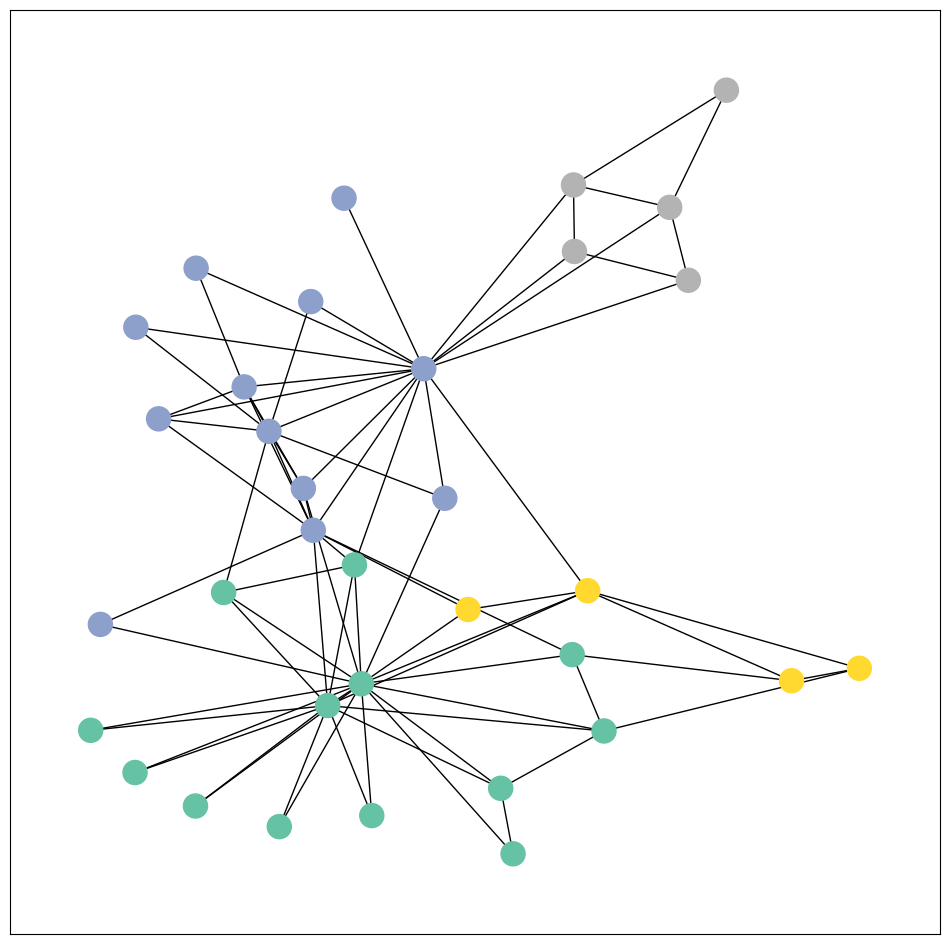

In [49]:
karateC_undirected_graph=to_networkx(data, to_undirected=True)
visualization_graph(karateC_undirected_graph, color=data.y)#, 
                    # labels="True")

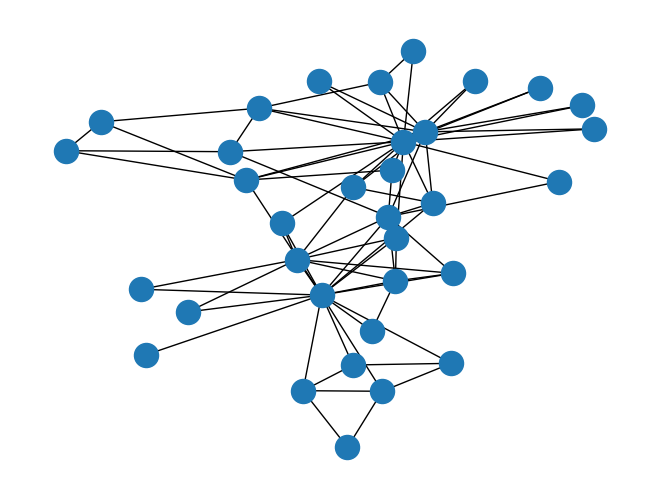

In [51]:
nx.draw(to_networkx(data, to_undirected=True)) #data format needs to be changed with `to_networkx()`

In [64]:
print(karateC_undirected_graph.nodes)
print(karateC_undirected_graph.number_of_nodes())
print(karateC_undirected_graph.edges)
print(karateC_undirected_graph.number_of_edges())
print(karateC_undirected_graph.degree)


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
34
[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 10), (0, 11), (0, 12), (0, 13), (0, 17), (0, 19), (0, 21), (0, 31), (1, 2), (1, 3), (1, 7), (1, 13), (1, 17), (1, 19), (1, 21), (1, 30), (2, 3), (2, 7), (2, 8), (2, 9), (2, 13), (2, 27), (2, 28), (2, 32), (3, 7), (3, 12), (3, 13), (4, 6), (4, 10), (5, 6), (5, 10), (5, 16), (6, 16), (8, 30), (8, 32), (8, 33), (9, 33), (13, 33), (14, 32), (14, 33), (15, 32), (15, 33), (18, 32), (18, 33), (19, 33), (20, 32), (20, 33), (22, 32), (22, 33), (23, 25), (23, 27), (23, 29), (23, 32), (23, 33), (24, 25), (24, 27), (24, 31), (25, 31), (26, 29), (26, 33), (27, 33), (28, 31), (28, 33), (29, 32), (29, 33), (30, 32), (30, 33), (31, 32), (31, 33), (32, 33)]
78
[(0, 16), (1, 9), (2, 10), (3, 6), (4, 3), (5, 4), (6, 4), (7, 4), (8, 5), (9, 2), (10, 3), (11, 1), (12, 2), (13, 5), (14, 2), (15, 2), (16, 2), (17

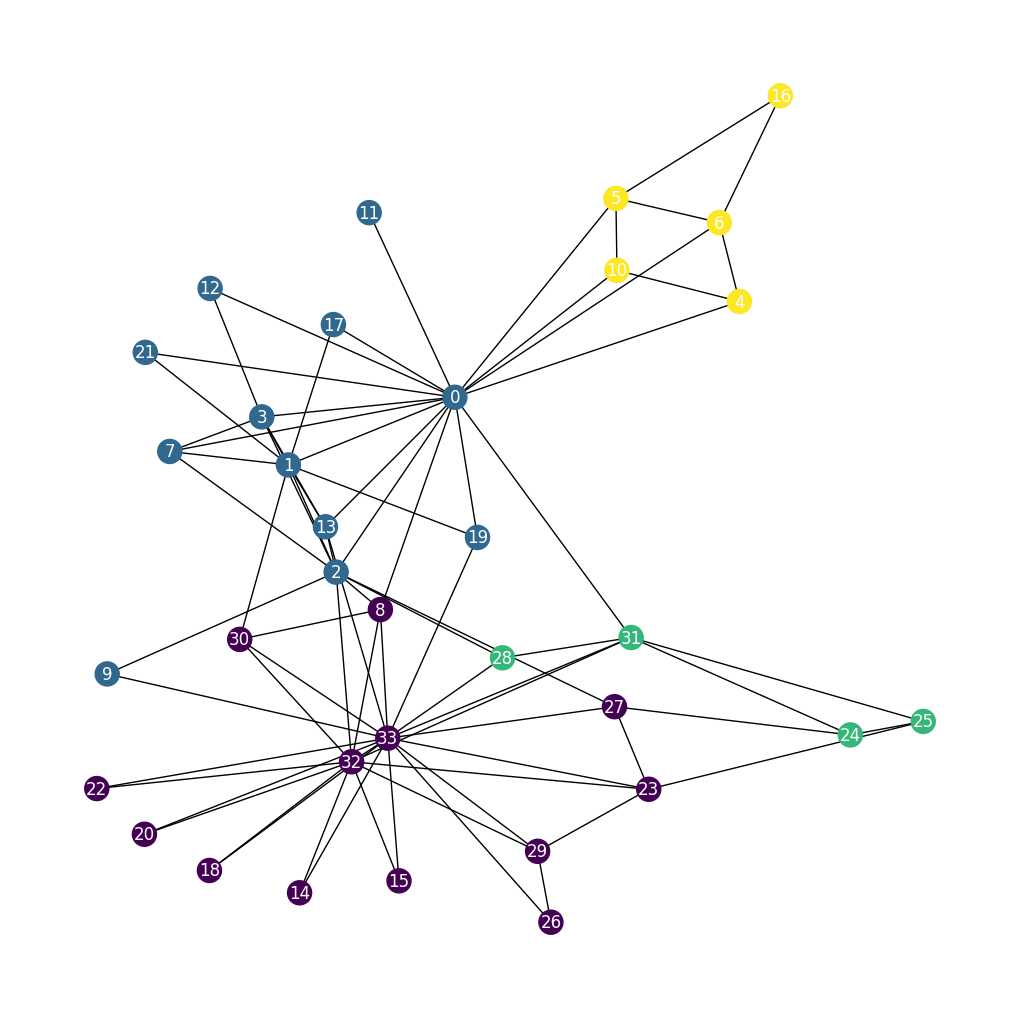

In [60]:
plt.figure(figsize=(10,10))
nx.draw(karateC_undirected_graph, cmap=plt.get_cmap('viridis'), 
        pos=nx.spring_layout(G=karateC_undirected_graph, seed=42), 
        with_labels=True, node_color=data.y, font_color='white')
# 4 Classes are visible

PyTG does not distinguish between directed and undirected graphs, and treats undirected graphs as a special case of directed graphs in which reverse edges exist for every entry in edge_index. It's just easy to *convert an undirected to a directed graph* using `to_undirected=False`

In [65]:
karate_directed_graph = to_networkx(data)